In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
import sklearn


import os
import PIL
import tensorflow as tf
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from pathlib import Path

data_directory = Path('class').resolve()

SIZE_IMAGE = 120

In [3]:
X, y = [], []
for dir in data_directory.iterdir():
    for file in dir.iterdir():
        img = cv2.imread(str(file))
        img = cv2.resize(img, (SIZE_IMAGE, SIZE_IMAGE))
        X.append(img)
        y.append(dir.name)

X = np.array(X)
y = np.array(y).reshape(-1, 1)
X.shape, y.shape

((1150, 120, 120, 3), (1150, 1))

In [4]:
y.shape

(1150, 1)

### Kodowanie obrazków, używam tutaj biblioteki sklearn, aby znormalizować labele klas
#### Trening

In [5]:
from sklearn import preprocessing
from keras.utils import to_categorical


In [6]:
a = tf.keras.utils.to_categorical([0,1,2,3], num_classes=4)
a = tf.constant(a, shape=[4,4])
print(a)

tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)


In [7]:
import pandas as pd
import numpy as np

bridge_types = ('Arch','Beam','Truss','Cantilever','Tied Arch','Suspension','Cable')

bridge_df = pd.DataFrame(bridge_types,columns=['Bridge_Types'])

#teraz używamy tego sklearna
labelencoder = preprocessing.LabelEncoder()
bridge_df['Bridge_Types_Cat'] = labelencoder.fit_transform(bridge_df['Bridge_Types'])
bridge_df

,Bridge_Types,Bridge_Types_Cat
0,Arch,0
1,Beam,1
2,Truss,6
3,Cantilever,3
4,Tied Arch,5
5,Suspension,4
6,Cable,2


In [8]:
y.shape

(1150, 1)

In [9]:
labelencoder = preprocessing.LabelEncoder()
if y.shape[1] == 1:
    #y = labelencoder.fit(y) #dopasowywanie etykiet
    #y = labelencoder.transform(y) #przekształcamy etykiety do znormalizowanego kodowania
    y = labelencoder.fit_transform(y)
    y = to_categorical(y, num_classes=2)
print(y.shape)

#zamieniamy y 
y = y.astype(int)
print(y)
print(y[0])
print(y[1149])

(1150, 2)
[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[1 0]
[0 1]


c:\Users\Przemek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Dzielenie na dane testowe i treningowe, z tutorialu z zajęć

In [10]:
from sklearn.model_selection import train_test_split
X = X/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((805, 120, 120, 3), (345, 120, 120, 3), (805, 2), (345, 2))

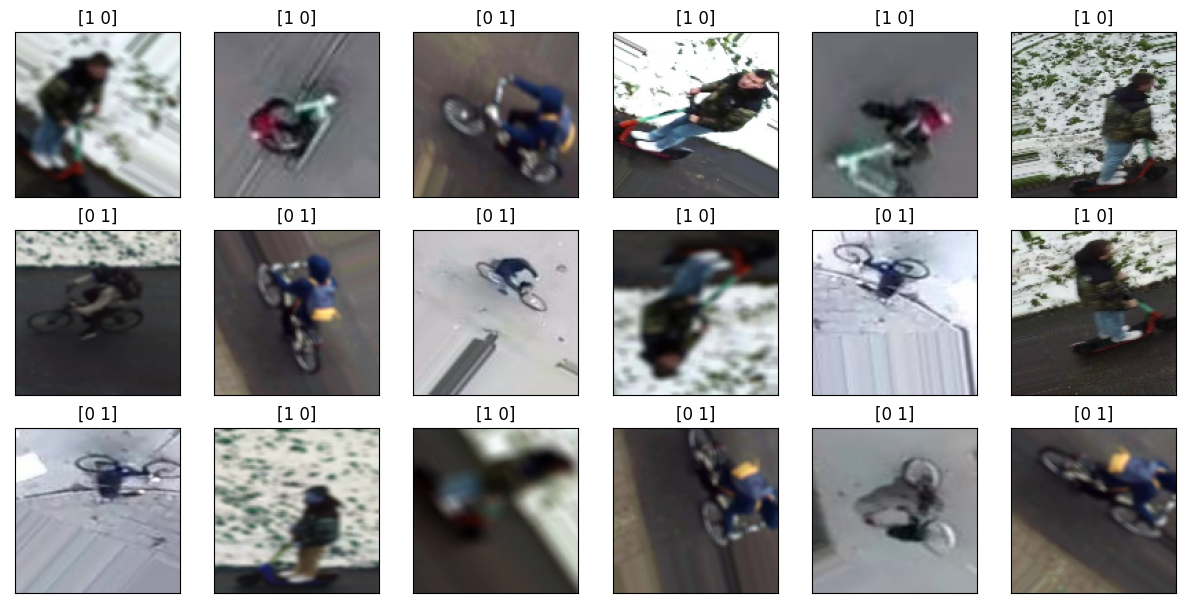

In [45]:
plt.figure(figsize=(15, 15))
for i in range(18):
    images = np.random.randint(0, len(X))
    plt.subplot(6, 6, i+1)
    plt.imshow(X[images])
    #plt.xlabel(y[images])
    plt.title(y[images])
    plt.xticks([])
    plt.yticks([])

    
    
plt.show()

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((805, 120, 120, 3), (805, 2), (345, 120, 120, 3), (345, 2))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D
import pydot
import graphviz

In [14]:
nnetwork = Sequential([
    Conv2D(filters=16,kernel_size=(3,3), activation='relu',padding='same', input_shape=(120,120,3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2)),
    #Flatten(input_shape=(120,120,3)),
    Flatten(),
    Dense(units=32,activation='relu'),
    Dense(units=2,activation='softmax')
])


In [15]:
nnetwork.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 32)                9

In [16]:
nnetwork.layers

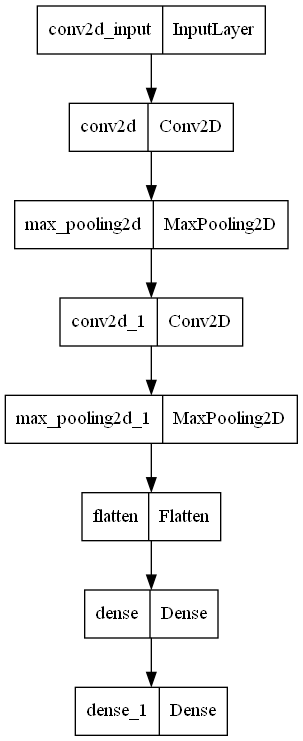

In [17]:
keras.utils.plot_model(nnetwork)

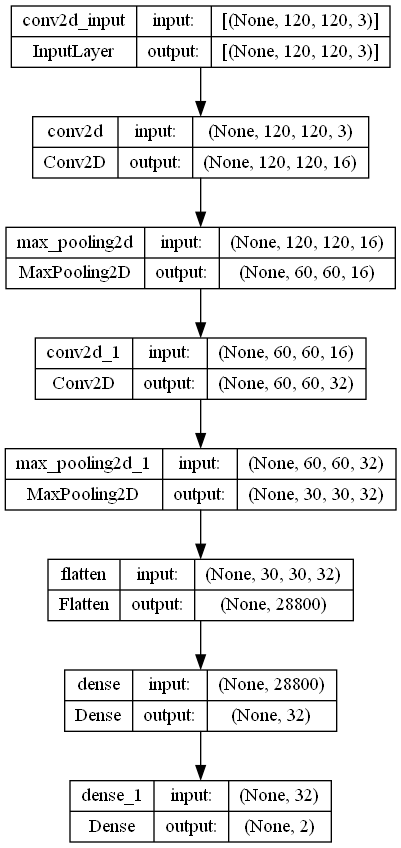

In [46]:
keras.utils.plot_model(nnetwork, "pierwszy_model_z_kształtami_warstw.png", show_shapes=True)

In [19]:
nnetwork.compile(
    optimizer = 'sgd',
    loss = 'categorical_crossentropy',
    #loss = 'mean_squared_error'
    metrics = ['accuracy']
)

In [20]:
X_train.shape

(805, 120, 120, 3)

### Używam callbacka EarlyStopping, aby zakońćzyć trening modelu jeśli przestał już się poprawiać

In [21]:
history = nnetwork.fit(X_train, y_train,
            epochs = 15,
            validation_data=(X_test,y_test),
            #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]
            

)

Epoch 1/15
26/26 [==============================] - 7s 222ms/step - loss: 0.6959 - accuracy: 0.5615 - val_loss: 0.7065 - val_accuracy: 0.5101
Epoch 2/15
26/26 [==============================] - 5s 192ms/step - loss: 0.6718 - accuracy: 0.6087 - val_loss: 0.8248 - val_accuracy: 0.5043
Epoch 3/15
26/26 [==============================] - 5s 180ms/step - loss: 0.6537 - accuracy: 0.6286 - val_loss: 0.7554 - val_accuracy: 0.5130
Epoch 4/15
26/26 [==============================] - 4s 172ms/step - loss: 0.6318 - accuracy: 0.6497 - val_loss: 0.8240 - val_accuracy: 0.5130
Epoch 5/15
26/26 [==============================] - 4s 172ms/step - loss: 0.6276 - accuracy: 0.6671 - val_loss: 0.6335 - val_accuracy: 0.6058
Epoch 6/15
26/26 [==============================] - 5s 174ms/step - loss: 0.5822 - accuracy: 0.7180 - val_loss: 0.8550 - val_accuracy: 0.5188
Epoch 7/15
26/26 [==============================] - 5s 180ms/step - loss: 0.5973 - accuracy: 0.6932 - val_loss: 0.5889 - val_accuracy: 0.6522
Epoch 

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
score = nnetwork.evaluate(X_test, y_test,verbose = 0)

print('Test loss:',score[0])
print('Test accuracy:', score[1])

Test loss: 0.5158116221427917
Test accuracy: 0.7362318634986877


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
label_values = ['hulajnoga', 'rower']

In [26]:
y_pred = np.argmax(nnetwork.predict(X_test),axis=1)

11/11 [==============================] - 1s 49ms/step


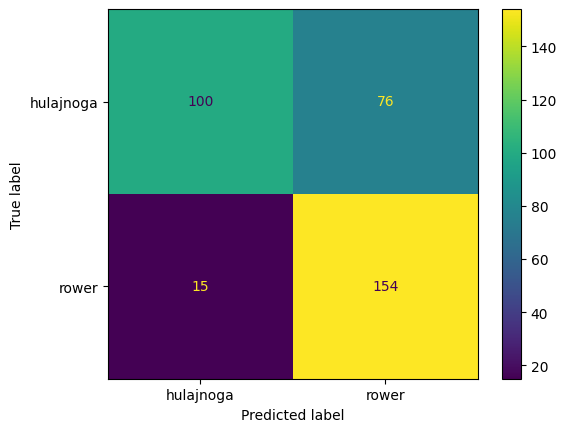

In [27]:
new_test1 = [label_values[i] for i in y_pred]
new_test2 = [label_values[i] for i in np.argmax(y_test, axis = 1)]

cm = confusion_matrix(new_test2, new_test1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_values
                              
                              
                              )
disp.plot()

26/26 [==============================] - 1s 48ms/step


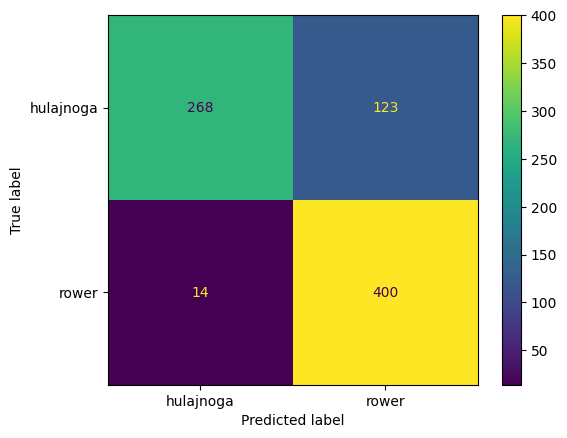

In [28]:
y_pred1 = np.argmax(nnetwork.predict(X_train),axis=1)

new_train1 = [label_values[i] for i in y_pred1]
new_train2 = [label_values[i] for i in np.argmax(y_train, axis = 1)]

cm = confusion_matrix(new_train2, new_train1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_values
                              
                              
                              )
disp.plot()

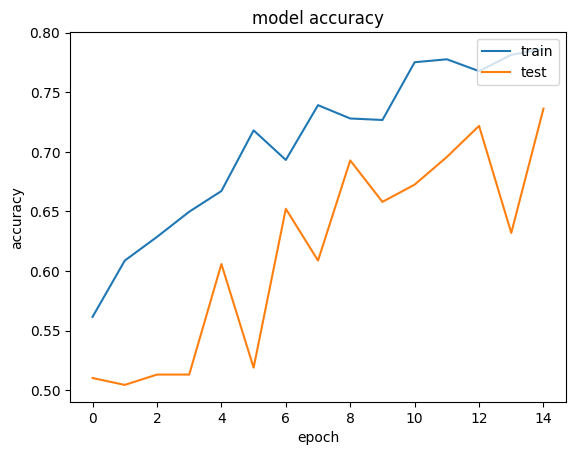

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = "upper right")
plt.show()

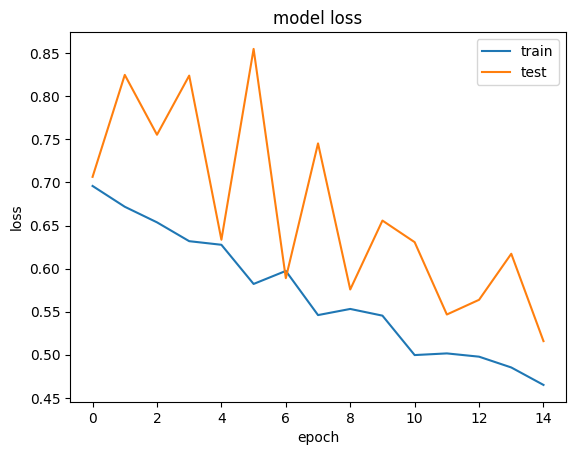

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = "upper right")
plt.show()

In [31]:
from tensorflow.keras.applications import ResNet50, vgg16
from tensorflow.keras.preprocessing import image 
import numpy as np
import tensorflow as tf

In [32]:
obraz = np.expand_dims(
    image.img_to_array(
        image.load_img('hulajnoga19.jpg',target_size=(224,224,3))
    ),axis=0
)

In [33]:
nn = tf.keras.applications.vgg16.VGG16(weights='imagenet')

In [34]:
y_prediction = nn.predict(obraz)
tf.keras.applications.vgg16.decode_predictions(y_prediction, top=2)

1/1 [==============================] - 0s 394ms/step


[[('n03788365', 'mosquito_net', 0.12612107),
  ('n03201208', 'dining_table', 0.07424875)]]

In [35]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [36]:
model_resnet = ResNet50()

In [37]:
transformedImage = preprocess_input(obraz)

In [38]:
transformedImage

array([[[[ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         ...,
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997]],

        [[ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         ...,
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997]],

        [[ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         [ 41.060997 ,  23.221    ,  15.32     ],
         ...,
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997],
         [ 26.060997 ,  12.221001 ,   7.3199997]],

        ...,

        [[ 15.060997 ,  -2.7789993, -1

In [39]:
prediction = model_resnet.predict(transformedImage)
#print(prediction)

1/1 [==============================] - 1s 1s/step


In [40]:
from tensorflow.keras.applications.resnet50 import decode_predictions

In [41]:
predictionLabel = decode_predictions(prediction, top=5)
predictionLabel

[[('n03075370', 'combination_lock', 0.121251434),
  ('n03532672', 'hook', 0.11719545),
  ('n04125021', 'safe', 0.07872836),
  ('n03976657', 'pole', 0.07245828),
  ('n02951585', 'can_opener', 0.072424985)]]

In [ ]:
from pathlib import Path

data_directory = Path('class').resolve()

SIZE_IMAGE = 120

In [ ]:
X, y = [], []
for dir in data_directory.iterdir():
    for file in dir.iterdir():
        img = cv2.imread(str(file))
        img = cv2.resize(img, (SIZE_IMAGE, SIZE_IMAGE))
        X.append(img)
        y.append(dir.name)

X = np.array(X)
y = np.array(y).reshape(-1, 1)
X.shape, y.shape